In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Objective
## 1. Create svm classifier to predict  Medium and Stress
# KR
## 1. Find unique combined labels
## 2. Compare classifier performance to the two separate classifiers
## 3. Find AUC/AUPRC values
## 4. Build Baseline Predictor using predictions of most occuring value
## 5. Compare Baseline performance 


In [41]:
#Load data 
df = pd.read_csv('ecs171.dataset.txt', sep='\s')
print(df.columns)

Index(['ID', 'Strain', 'Medium', 'Stress', 'GenePerturbed', 'GrowthRate',
       'b3356', 'b2922', 'b2519', 'b3823',
       ...
       'b4673', 'b4684', 'b4689', 'b4685', 'b4683', 'b4682', 'b4699', 'b4698',
       'b4704', 'b4703'],
      dtype='object', length=4501)


In [42]:
#Get features and labels
X = df.iloc[:,6:].values
Medium = df.Medium
Stress = df.Stress


In [43]:
#Function that finds unique Medium and Stress values and concats them together and then gives its integer mapping
def int_mapping(arr1,arr2):
    unique_1 = arr1.unique() #Find unique values in list1
    unique_2 = arr2.unique() #Find unique values in list2
    combine_list = []     #Initialize list to hold unique value pairings
    for i in unique_1:    #Iterate through unique values in list 1
        for j in unique_2:  #Iterate through unique values in list 2
            combined_val = i+j #Combine the unique values 
            combine_list.append(combined_val) #Append this to empty list initialized earlier
    combine_list = np.array(combine_list) #Convert to array
    tot = combine_list.shape[0]     
    combine_list = np.reshape(combine_list,[tot,1])
    mapping = np.reshape(np.linspace(0,tot-1,tot) , [tot,1])
    #Return an array where first column is the label and the second column is the label assigned to it 
    return (np.concatenate((combine_list,mapping), axis =1))   
    

In [44]:
#Find integer mappings for all possible combinations of Medium and Stress
mappings = int_mapping(Medium,Stress)

In [45]:
#Def convert labels based on mapping found earlier
def convert_mapping(arr1,arr2,mappings):
    combined_labels = arr1+arr2  #Combine the labels
    final_mapping= []   #Initialize empty list
    for i in combined_labels:# Iterate through actual labels
        for j in range(mappings.shape[0]):  #Iterate through mapping found earlier
            if i == mappings[j,0]:   # Check if i matches mapping
                final_mapping.append(mappings[j,1])    #Append label assigned to that mapping
    final_mapping = np.array(final_mapping)
    final_mapping = final_mapping.astype(float)  # Convert labels to float
    return final_mapping

In [46]:
def binarize_labels(Y):
    unique = np.unique(Y)
    return label_binarize(Y, classes = unique)

In [47]:
#Get labels and binarize these labels based on unique values
#HERE WE MAKE THE ASSUMPTION THAT THE UNIQUE PAIRINGS ARE THE ONLY PAIRINGS AVAILABLE AND THE OTHER PAIRINGS THAT WE HAD FOUND EARLIER DONT EXIST IN PRACTICE
Y = convert_mapping(Medium,Stress,mappings)

In [48]:
#Use the same ROC, and PR CURVE FUNCTION AS PART 4
def ROC_Curve(X,Y,name):
    one_hot = binarize_labels(Y)
    preds = []
    true = []
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(X,Y):
        classifier = OneVsRestClassifier(svm.SVC(kernel='linear', C=1))
        predict = classifier.fit(X[train], one_hot[train]).predict(X[test])
        preds.extend(predict.ravel().tolist())
        true.extend(one_hot[test].ravel().tolist())
    fpr, tpr, _ = roc_curve(true, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,
             label='ROC curve (area = {0:0.2f})'''.format(roc_auc), linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--',)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for Combined {}'.format(name))
    plt.legend(loc="lower right")
    plt.savefig('ROC{}.pdf'.format(name))
    plt.show()
    

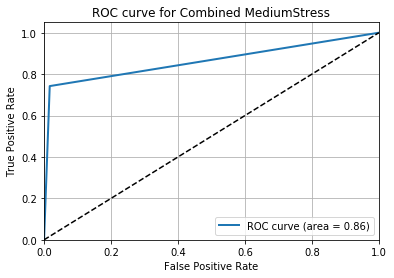

In [49]:
ROC_Curve(X,Y,"MediumStress")

In [50]:
def PR_Curve(X,Y,name):
    one_hot = binarize_labels(Y)
    preds = []
    true = []
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(X,Y):
        classifier = OneVsRestClassifier(svm.SVC(kernel='linear', C=1))
        predict = classifier.fit(X[train], one_hot[train]).predict(X[test])
        preds.extend(predict.ravel().tolist())
        true.extend(one_hot[test].ravel().tolist())
    precision, recall, _ = precision_recall_curve(true, preds)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision,
             label='PR curve (area = {0:0.2f})'''.format(pr_auc), linewidth=2)

    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve for Combined {}'.format(name))
    plt.legend(loc="lower right")
    plt.savefig('PR{}.pdf'.format(name))
    plt.show()
    

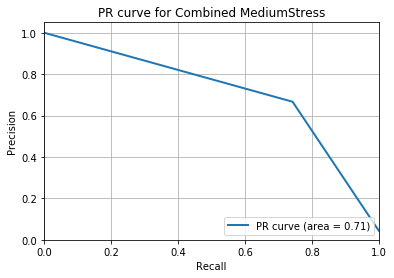

In [51]:
PR_Curve(X,Y,"MediumStress")

In [59]:
#Base line Predictor
#Find max occurences of a label and use that for predictions
unique = np.unique(Y)
for i in unique:
    print("Number of unique values for {} is {}".format(i,(Y==i).sum()))

Number of unique values for 0.0 is 36
Number of unique values for 1.0 is 18
Number of unique values for 2.0 is 5
Number of unique values for 7.0 is 16
Number of unique values for 14.0 is 6
Number of unique values for 24.0 is 13
Number of unique values for 29.0 is 5
Number of unique values for 35.0 is 6
Number of unique values for 45.0 is 12
Number of unique values for 49.0 is 6
Number of unique values for 53.0 is 6
Number of unique values for 56.0 is 2
Number of unique values for 61.0 is 8
Number of unique values for 63.0 is 3
Number of unique values for 70.0 is 15
Number of unique values for 78.0 is 1
Number of unique values for 84.0 is 11
Number of unique values for 91.0 is 3
Number of unique values for 97.0 is 5
Number of unique values for 98.0 is 2
Number of unique values for 105.0 is 1
Number of unique values for 112.0 is 7
Number of unique values for 119.0 is 7


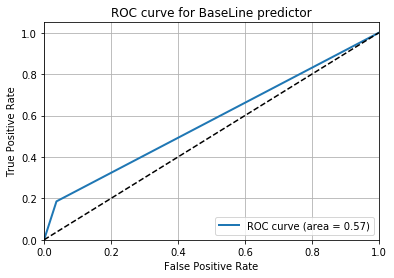

In [81]:
#Use 0 to predict for all 
predictions = np.zeros((X.shape[0],23))
predictions[:,0]=1
predictions = predictions.ravel()
y_one_hot = binarize_labels(Y).ravel()
#Plot ROC Curve
fpr, tpr, _ = roc_curve(y_one_hot, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr,
         label='ROC curve (area = {0:0.2f})'''.format(roc_auc), linewidth=2)

plt.plot([0, 1], [0, 1], 'k--',)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for BaseLine predictor')
plt.legend(loc="lower right")
plt.savefig('BaselineROC')
plt.show()


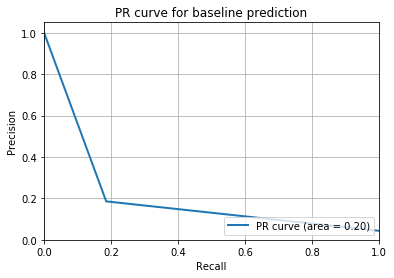

In [83]:
#Plot Precision Recall Curve
precision, recall, _ = precision_recall_curve(y_one_hot, predictions)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision,
         label='PR curve (area = {0:0.2f})'''.format(pr_auc), linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve for baseline prediction')
plt.legend(loc="lower right")
plt.savefig("BaselinePR")
plt.show()